In [48]:
!pip install geoip2
# !pip install pygeoip

In [49]:
import pandas as pd
import re
import os
import requests
# import geoip2.database

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
print(os.listdir())

['.config', 'drive', 'sample_data']


In [73]:
filename = '/content/drive/MyDrive/web-analytics-synchuk/access_log.csv'
df = pd.read_csv(filename, sep = ',', parse_dates=['timestamp'],encoding='utf-8-sig')

In [74]:
df.head

<bound method NDFrame.head of       Unnamed: 0               ip                 timestamp  \
0              0      1.202.218.8 2012-06-20 19:05:12+02:00   
1              1   208.115.113.91 2012-06-20 19:20:16+02:00   
2              2    123.125.71.20 2012-06-20 19:30:40+02:00   
3              3  220.181.108.101 2012-06-20 19:31:01+02:00   
4              4    123.125.68.79 2012-06-20 19:53:24+02:00   
...          ...              ...                       ...   
2103        2103    203.143.31.75 2012-07-02 09:24:11+02:00   
2104        2104    203.143.31.75 2012-07-02 09:24:13+02:00   
2105        2105    203.143.31.75 2012-07-02 09:24:14+02:00   
2106        2106    108.163.244.2 2012-07-02 09:36:46+02:00   
2107        2107    108.163.244.2 2012-07-02 09:36:46+02:00   

                            request  status  bytes_sent  \
0          GET /robots.txt HTTP/1.0     404         492   
1       GET /logs/?C=M;O=D HTTP/1.1     200        1278   
2                    GET / HTTP/1.1     200         912   
3                    GET / HTTP/1.1     200         912   
4                    GET / HTTP/1.1     200         625   
...                             ...     ...         ...   
2103  GET /logs/access.log HTTP/1.1     200      336934   
2104      GET /favicon.ico HTTP/1.1     404         502   
2105      GET /favicon.ico HTTP/1.1     404         502   
2106                 GET / HTTP/1.1     200         897   
2107                 GET / HTTP/1.1     200         889   

                                               referrer  \
0                                                     -   
1                                                     -   
2                                                     -   
3                                                     -   
4                                                     -   
...                                                 ...   
2103  http://www.google.com/url?sa=t&rct=j&q=&esrc=s...   
2104                                                  -   
2105                                                  -   
2106                                                  -   
2107                                                  -   

                                             user_agent        date  \
0                                                     \  2012-06-20   
1     Mozilla/5.0 (compatible; Ezooms/1.0; ezooms.bo...  2012-06-20   
2     Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...  2012-06-20   
3     Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...  2012-06-20   
4     Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...  2012-06-20   
...                                                 ...         ...   
2103  Mozilla/5.0 (Ubuntu; X11; Linux x86_64; rv:8.0...  2012-07-02   
2104  Mozilla/5.0 (Ubuntu; X11; Linux x86_64; rv:8.0...  2012-07-02   
2105  Mozilla/5.0 (Ubuntu; X11; Linux x86_64; rv:8.0...  2012-07-02   
2106  Mozilla/5.0 (Windows; U; MSIE 6.0; Windows NT ...  2012-07-02   
2107  Mozilla/5.0 (Windows; U; MSIE 6.0; Windows NT ...  2012-07-02   

              endpoint  
0          /robots.txt  
1       /logs/?C=M;O=D  
2                    /  
3                    /  
4                    /  
...                ...  
2103  /logs/access.log  
2104      /favicon.ico  
2105      /favicon.ico  
2106                 /  
2107                 /  

[2108 rows x 10 columns]>

In [75]:
# кількість користувачів за днями
df.groupby('date')['ip'].nunique()

date
2012-06-20    21
2012-06-21    69
2012-06-22    68
2012-06-23    83
2012-06-24    78
2012-06-25    73
2012-06-26    90
2012-06-27    73
2012-06-28    88
2012-06-29    93
2012-06-30    98
2012-07-01    82
2012-07-02    30
Name: ip, dtype: int64

In [76]:
# ранжувати користувачів за user-agent
df.groupby('user_agent')['ip'].nunique().sort_values(ascending=False)

user_agent
Mozilla/5.0 (compatible; Baiduspider/2.0; +http://www.baidu.com/search/spider.html)                         193
Mozilla/5.0 (compatible; MJ12bot/v1.4.3; http://www.majestic12.co.uk/bot.php?+)                              32
Mozilla/5.0 (compatible; AhrefsBot/3.1; +http://ahrefs.com/robot/)                                           22
Mozilla/5.0 (Windows NT 5.1; rv:6.0.2) Gecko/20100101 Firefox/6.0.2                                          15
Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)                                     13
                                                                                                           ... 
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.1 (KHTML, like Gecko) Chrome/14.0.814.0 Safari/535.1      1
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/536.5 (KHTML, like Gecko) Chrome/19.0.1084.56 Safari/536.5           1
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/535.19 (KHTML, like Gecko) Chrome/18.0.1025.1 Safari

In [77]:
# ранжувати користувачів за операційними системами
# ex. : Mozilla/5.0 (Windows NT 5.1; rv:6.0.2) Gecko/20100101 Firefox/6.0.2
# => Windows                                      15
def extract_parentheses_content(user_agent_str: str) -> str | None:
    pattern = r'\((.*?)\)'
    match_ = re.search(pattern, user_agent_str)
    return match_.group(1) if match_ else None


def identify_os(content: str) -> str:
    # Define patterns for known operating systems
    os_patterns = {
        'Windows': r'Windows',
        'Mac OS': r'Macintosh|Mac OS|Mac_PowerPC',
        'Linux': r'Linux',
        'Android': r'Android',
        'iOS': r'iPhone|iPad|iPod',
        'Chrome OS': r'CrOS'
    }

    for os, pattern in os_patterns.items():
        if re.search(pattern, content, re.IGNORECASE):
            return os
    return 'Unknown'

def extract_os_from_user_agent(user_agent_str: str) -> str:
    content = str(extract_parentheses_content(user_agent_str))
    return identify_os(content)


df['os'] = df['user_agent'].apply(extract_os_from_user_agent)
df.groupby('os')['ip'].nunique()

os
Linux       10
Mac OS       2
Unknown    329
Windows    119
Name: ip, dtype: int64

In [78]:
print(df['user_agent'].unique())

['\\' 'Mozilla/5.0 (compatible; Ezooms/1.0; ezooms.bot@gmail.com)'
 'Mozilla/5.0 (compatible; Baiduspider/2.0; +http://www.baidu.com/search/spider.html)'
 'Mozilla/5.0 (compatible; YandexBot/3.0; +http://yandex.com/bots)'
 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; .NET CLR 1.1.4322; .NET CLR 2.0.50727; .NET CLR 3.0.04506.648; .NET CLR 3.5.21022; InfoPath.2; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729)'
 'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.0; Trident/4.0; Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1) ; .NET CLR 3.5.30729)'
 'Mozilla/5.0 (compatible; MJ12bot/v1.4.3; http://www.majestic12.co.uk/bot.php?+)'
 'Mozilla/5.0 (compatible; AhrefsBot/3.0; +http://ahrefs.com/robot/)'
 'Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)'
 'findlinks/2.6 (+http://wortschatz.uni-leipzig.de/findlinks/)'
 'Baiduspider-image+(+http://www.baidu.com/search/spider.htm)'
 'Aboundex/0.2 (http://www.aboundex.com/crawler/)'
 'SeznamBot/3.0 (+http://fulltext

In [79]:
# Ранжувати користувачів за країною запиту
import geoip2.database
# reader = geoip2.database.Reader('/content/drive/MyDrive/web-analytics-synchuk/GeoLite2-City.mmdb')
reader = geoip2.database.Reader('/content/drive/MyDrive/web-analytics-synchuk/GeoLite2-Country.mmdb')

# def get_country_from_ip(ip: str) -> str:
#     response = requests.get(f"https://geolocation-db.com/json/{ip}&position=true").json()
#     # print(response)
#     return response['country_name']

def get_country_from_ip(ip: str, reader) -> str:
    try:
        response = reader.country(ip)
        return response.country.name
    except Exception:
        return 'Unknown'


df['country'] = df['ip'].apply(lambda ip: get_country_from_ip(ip, reader))

In [80]:
df.groupby('country')['ip'].nunique().sort_values(ascending=False)

country
China              193
United States      102
Japan               24
Russia              22
France              14
Germany             14
Ukraine             12
The Netherlands      6
United Kingdom       5
Brazil               5
Czechia              5
Indonesia            5
India                4
Israel               4
Norway               4
Romania              2
Sweden               2
Ecuador              2
Canada               2
Thailand             2
Malaysia             2
Argentina            1
Türkiye              1
Sri Lanka            1
Venezuela            1
Sudan                1
Luxembourg           1
Spain                1
South Africa         1
Poland               1
Belgium              1
Iran                 1
Hungary              1
Hong Kong            1
Ghana                1
Finland              1
Egypt                1
Vietnam              1
Name: ip, dtype: int64

In [81]:
# Виокремити пошукових ботів

known_bots = ['Googlebot', 'Bingbot', 'Yahoo! Slurp', 'DuckDuckBot', 'Baiduspider']
# Identify bots in the User-Agent column and create a new 'Bot' column
df['bot'] = df['user_agent'].apply(
    lambda user_agent: next((bot for bot in known_bots if bot in user_agent), None)
)
df.groupby('bot')['ip'].nunique().sort_values(ascending=False)

bot
Baiduspider    206
Googlebot       13
Name: ip, dtype: int64

In [82]:
df.head()

,Unnamed: 0,ip,timestamp,request,status,bytes_sent,referrer,user_agent,date,endpoint,os,country,bot
0,0,1.202.218.8,2012-06-20 19:05:12+02:00,GET /robots.txt HTTP/1.0,404,492,-,\,2012-06-20,/robots.txt,Unknown,China,None
1,1,208.115.113.91,2012-06-20 19:20:16+02:00,GET /logs/?C=M;O=D HTTP/1.1,200,1278,-,Mozilla/5.0 (compatible; Ezooms/1.0; ezooms.bo...,2012-06-20,/logs/?C=M;O=D,Unknown,United States,None
2,2,123.125.71.20,2012-06-20 19:30:40+02:00,GET / HTTP/1.1,200,912,-,Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...,2012-06-20,/,Unknown,China,Baiduspider
3,3,220.181.108.101,2012-06-20 19:31:01+02:00,GET / HTTP/1.1,200,912,-,Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...,2012-06-20,/,Unknown,China,Baiduspider
4,4,123.125.68.79,2012-06-20 19:53:24+02:00,GET / HTTP/1.1,200,625,-,Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...,2012-06-20,/,Unknown,China,Baiduspider


In [84]:
df['hour'] = df['timestamp'].dt.hour
df['hour']

0       19
1       19
2       19
3       19
4       19
        ..
2103     9
2104     9
2105     9
2106     9
2107     9
Name: hour, Length: 2108, dtype: int32

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


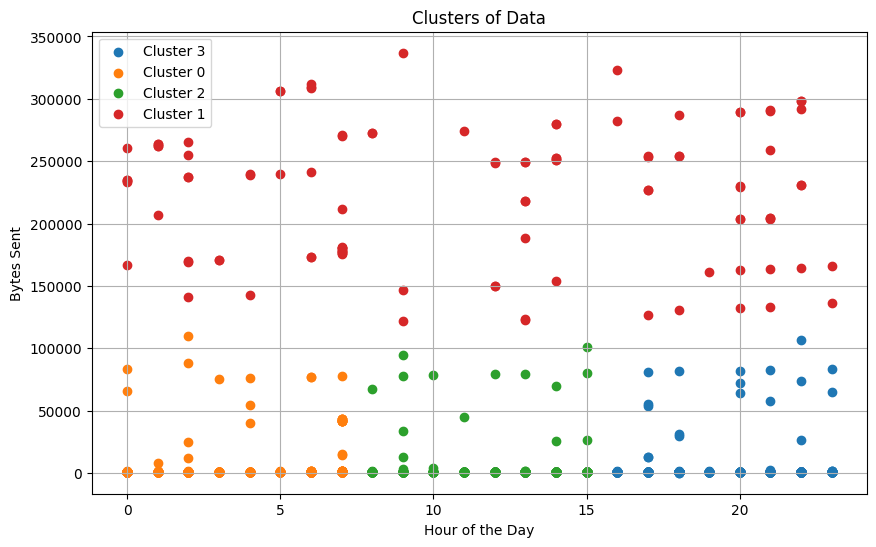

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = df[['hour', 'bytes_sent']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=4)
df['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
for cluster_label in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster_label]

    plt.scatter(cluster_data['hour'], cluster_data['bytes_sent'],
    label=f'Cluster {cluster_label}')

plt.xlabel('Hour of the Day')
plt.ylabel('Bytes Sent')
plt.title('Clusters of Data')
plt.legend()
plt.grid(True)
plt.show()